# Imports

## Libs

In [2]:
# Setting seed for reproducability
SEED = 42

# Numpy
import numpy as np
np.random.seed(SEED)

# Pandas
import pandas as pd

# Sklearn

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import cross_validate, learning_curve, train_test_split

# Metrics and tuning
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn import svm

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense

# Stats
from scipy import stats

# Vizualization
import seaborn as sns
sns.set(style="whitegrid")

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Other
import pandas_profiling

## Custom functions

In [3]:
def histograms_numeric_columns(df, numerical_columns):
    '''
    Takes df, numerical columns as list
    Returns a group of histagrams
    '''
    f = pd.melt(df, value_vars=numerical_columns) 
    g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
    g = g.map(sns.distplot, 'value')
    return g

def heatmap_numeric_w_dependent_variable(df, dependent_variable):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of all independent variables' correlations with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    g = sns.heatmap(df.corr()[[dependent_variable]].sort_values(by=dependent_variable), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1) 
    return g

def cramers_v(x, y):
    '''
    Returns cramers_v for 2 categorical features
    '''
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

def heatmap_categorical_columns_w_dependant_categorical(df, dependent_variable, columns):
    '''
    Takes df, a dependant variable as str
    Returns a heatmap of catecorical columns cramers_v with dependent variable 
    '''
    plt.figure(figsize=(8, 10))
    corrM = [cramers_v(df[dependent_variable], df[column]) for column in columns]
    corr = pd.DataFrame(corrM, index=columns, columns=[dependent_variable])
    ax = sns.heatmap(corr,
            annot=True,
            cmap='coolwarm', 
            vmin=-1,
            vmax=1,
           )
    ax.set_title("Cramer V Correlation between Variables")
    return ax

# Preprocessing

## Data

Dataset: Breast Cancer (METABRIC, Nature 2012 & Nat Commun 2016)

Targeted sequencing of 2509 primary breast tumors with 548 matched normals

Link: http://www.cbioportal.org/study/summary?id=brca_metabric

Related article: https://www.ncbi.nlm.nih.gov/pubmed/27161491

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/OzmundSedler/IBM-advanced-DS-coursera/master/4%20Capstone%20/brca_metabric_clinical_data.tsv', sep='\t')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 35 columns):
Study ID                          2509 non-null object
Patient ID                        2509 non-null object
Sample ID                         2509 non-null object
Age at Diagnosis                  2498 non-null float64
Type of Breast Surgery            1955 non-null object
Cancer Type                       2509 non-null object
Cancer Type Detailed              2374 non-null object
Cellularity                       1917 non-null object
Chemotherapy                      1980 non-null object
Pam50 + Claudin-low subtype       1980 non-null object
Cohort                            2498 non-null float64
ER status measured by IHC         2426 non-null object
ER Status                         2469 non-null object
Neoplasm Histologic Grade         2388 non-null float64
HER2 status measured by SNP6      1980 non-null object
HER2 Status                       1980 non-null object
Tumor Othe

In [6]:
len(df['Patient ID'].unique())

2509

## Problem definition. Target Selecting

As a goal of this project I want to make Living Status prognosis of a patient (Alive/Dead), based on an patient's primary tests. As we see there are 2 variables we must look into to make such predictions - overall survival and living status.

First of all, to study them we need to drop columns, where this to parameters are not defined - either we can't work further:

In [7]:
df = df.dropna(subset=["Overall Survival (Months)", "Patient's Vital Status"])

In [8]:
print(f'Number of patients with known target data: {df.shape[0]}')

Number of patients with known target data: 1980


### Target selecting

As we see, there are 2 variables we must look into to make such predictions - overall survival and living status.

But we must remember that overall survival is a fixed number of the month when the last analysis is made. So, for example, overall status == 160 months does not mean that the patient died after that - we do not know what happened after. As we want to predict living status due to parameters of the patient, we need to set a minimum border of months to predict status for. 

Let's look at the overall survival feature.

In [9]:
overall_survival_month = df['Overall Survival (Months)']

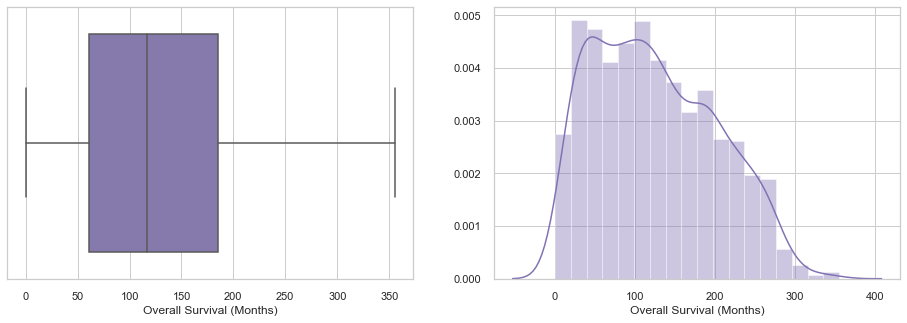

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

sns.boxplot(overall_survival_month, palette=["m", "g"], ax=axs[0])
sns.distplot(overall_survival_month, color="m", ax=axs[1])

Let's look at how many values lying before five years border? (The five-year survival rate is a typical measurement for diseases).

Link: https://en.wikipedia.org/wiki/Five-year_survival_rate

In [12]:
overall_survival_month.where(overall_survival_month < 60).count()

491

And how many of them have 'Living' status ?

In [13]:
df.where((df["Overall Survival (Months)"] < 60.) & (df["Patient's Vital Status"] == 'Living'))["Patient's Vital Status"].count()

64

So, we got 64 living patients. If we exclude them, we will get only patients that survived more than 5 years or the ones who died before. 

In [14]:
df = df.drop(df[(df["Overall Survival (Months)"] < 60.) & (df["Patient's Vital Status"] == 'Living')].index)

In [15]:
print(f'Number of patients with known 5 year status: {df.shape[0]}')

Number of patients with known 5 year status: 1916


Now we can drop the "Overall Survival (Months)" feature and proceed further with "Patient's Vital Status" as a target

In [354]:
df = df.drop(columns=["Overall Survival (Months)"])

### Target encoding

Now, we need to change our target to chosen (Living/Dead) status. Let's take a look at its values:

In [16]:
df["Patient's Vital Status"].value_counts()

Living                  773
Died of Disease         646
Died of Other Causes    497
Name: Patient's Vital Status, dtype: int64

Ok, so all we have to do is sum up 'Died' statuses and then change strings to int:

In [17]:
df["Patient's Vital Status"] = df["Patient's Vital Status"].map({
    'Died of Disease': 0,
    'Died of Other Causes': 0,
    'Living': 1
})

In [18]:
df["Patient's Vital Status"].value_counts()

0    1143
1     773
Name: Patient's Vital Status, dtype: int64

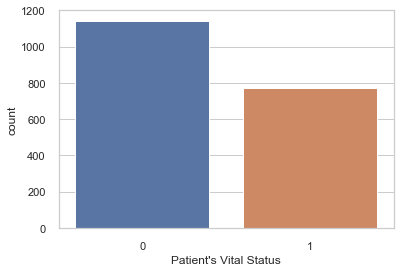

In [19]:
ax = sns.countplot(df["Patient's Vital Status"], label="Patient's Vital Status")

OK, so now we got 1916 patients, that we have data on after 5 years. 

## Preprocessing

### Basic data cleaning

First of all, let's drop obviously unnecessary columns such as:

1. **ID's:**<br>
    1.1 **Study ID** - we are not interested in this one<br>
    1.2. **Patient ID** - we do not need this too (we ensured, that this feature is unique)<br>
    1.3. **Sample ID**<br>
    
    
2. **Not relevant or doc-information columns:**<br>
    2.1.**"Oncotree" Code**<br>
    2.2. **Cancer type** - all the same after dropping 2 rows with Breast Sarcoma - outliers (we want to study only exactly breast cancer cases, also 3 raws will certainly be not enough to study different cancer type in this project)<br>
    2.3. **Sample type** - all the same<br>
    2.4. **Number of Samples Per Patient** - all the same<br>
    2.5. **Cohort** - not relevant<br>
    2.6. **Overall Survival Status** - we will use Patient Vital status instead<br>

In [20]:
df = df.drop(df.loc[df['Cancer Type']=='Breast Sarcoma'].index)

In [21]:
df = df.drop(columns=[
    'Study ID',
    'Sample ID',
    'Patient ID',
    'Oncotree Code',
    'Cancer Type',
    'Sample Type',
    'Number of Samples Per Patient',
    'Cohort',
    'Overall Survival Status',
])

As mentioned in the problem definition, we want to make predictions based only on a patient's initial tests. So, the first thing that we want to exclude from our datasets is future knowledge about patient treatment, not related to initial tests.

Columns deleted:
1. **Chemotherapy** - Future
2. **Hormone Therapy** - Future
3. **Radio Therapy** - Future
4. **Type of Breast Surgery** - Future
5. **Nottingham prognostic index** - is used to determine prognosis following surgery for breast cancer - Future

In [355]:
df = df.drop(columns=['Chemotherapy', 'Hormone Therapy', 'Radio Therapy', 'Type of Breast Surgery', 'Nottingham prognostic index'])

KeyError: "['Chemotherapy' 'Hormone Therapy' 'Radio Therapy' 'Type of Breast Surgery'\n 'Nottingham prognostic index'] not found in axis"

### Missing values

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914 entries, 0 to 1984
Data columns (total 21 columns):
Age at Diagnosis                  1914 non-null float64
Cancer Type Detailed              1875 non-null object
Cellularity                       1852 non-null object
Pam50 + Claudin-low subtype       1913 non-null object
ER status measured by IHC         1876 non-null object
ER Status                         1914 non-null object
Neoplasm Histologic Grade         1832 non-null float64
HER2 status measured by SNP6      1913 non-null object
HER2 Status                       1913 non-null object
Tumor Other Histologic Subtype    1875 non-null object
Inferred Menopausal State         1913 non-null object
Integrative Cluster               1913 non-null object
Primary Tumor Laterality          1809 non-null object
Lymph nodes examined positive     1844 non-null float64
Mutation Count                    1802 non-null float64
Overall Survival (Months)         1914 non-null float64
PR Statu

In [24]:
df['Neoplasm Histologic Grade'] = df['Neoplasm Histologic Grade'].astype('category')

numeric_cols = ['Age at Diagnosis', 'Lymph nodes examined positive','Mutation Count', 'Tumor Size']
categorical_cols = list(set(df.columns.values.tolist()) - set(numeric_cols))

Let's use some usefull tools to checkout correlation and decide if we have some unnecessary information left

In [ ]:
df.profile_report(style={'full_width':True})

There are no obviously suspicious places, so let's dig into the data

First of all, let's check how many data we lose if we drop NaN columns:

In [25]:
(df.dropna().shape[0])/(df.shape[0])*100

55.43364681295716

Okay, it's obviously not an option. Than, let's start to work on it.

#### Cancer Type Detailed and Tumor Other Histologic Subtype

In [26]:
df['Cancer Type Detailed'].unique()

array(['Breast Invasive Ductal Carcinoma',
       'Breast Mixed Ductal and Lobular Carcinoma',
       'Breast Invasive Lobular Carcinoma', nan,
       'Breast Invasive Mixed Mucinous Carcinoma', 'Breast',
       'Metaplastic Breast Cancer'], dtype=object)

All of the types are obviously types of Breast cancer, so the 'Breast' category is something like a NaN category (not detailed type in detailed types), so let's assign all NaN to this category not to create one more. We do the same for 'Tumor Other Histologic Subtype' - assign 'Other' value.

In [27]:
df.fillna({'Cancer Type Detailed': 'Breast', 'Tumor Other Histologic Subtype': 'Other'}, inplace=True)

Now, when we fixed Nan values in these columns, we can check the correlation between them:

In [28]:
df[['Cancer Type Detailed', 'Tumor Other Histologic Subtype']].head(10)

,Cancer Type Detailed,Tumor Other Histologic Subtype
0,Breast Invasive Ductal Carcinoma,Ductal/NST
1,Breast Invasive Ductal Carcinoma,Ductal/NST
2,Breast Invasive Ductal Carcinoma,Ductal/NST
3,Breast Mixed Ductal and Lobular Carcinoma,Mixed
4,Breast Mixed Ductal and Lobular Carcinoma,Mixed
5,Breast Invasive Ductal Carcinoma,Ductal/NST
6,Breast Invasive Ductal Carcinoma,Ductal/NST
7,Breast Invasive Lobular Carcinoma,Lobular
8,Breast Mixed Ductal and Lobular Carcinoma,Mixed
10,Breast Invasive Ductal Carcinoma,Ductal/NST


In [29]:
cramers_v(df['Cancer Type Detailed'], df['Tumor Other Histologic Subtype'])

0.9994757535681643

These two variables are the same - we can drop one of them

In [30]:
df = df.drop(columns=['Cancer Type Detailed'])

In [31]:
categorical_cols.remove('Cancer Type Detailed')

#### ER status and ER status measured by IHC

In [ ]:
unique_count = 0

for x, raw in df.iterrows():
    if not (pd.isnull(raw['ER status measured by IHC'])):
        if raw['ER status measured by IHC'] != raw['ER Status']:
            if raw['ER status measured by IHC'] == 'Positve' and raw['ER Status'] == 'Positive':
                continue
            unique_count += 1

print(x)
print(f'Percent where statuses differs: {(unique_count/x)*100}')

On 6.5 percent of patients, these two features differ. There are various opportunities to choose from. We can drop one of these columns due to the high correlation between them. We can fill NaN values from the second column due to the first one. We can fill NaN values in many other ways. Let's check out the correlation between these features:

In [ ]:
cramers_v(df['ER status measured by IHC'], df['ER Status'])

Cramers V is high, but not as in the previous example so we will leave these features for now. But we still need to solve the problem of missing values.

In [ ]:
df['ER status measured by IHC'].unique()

In [ ]:
df['ER Status'].unique()

The simplest way with the correlation this high is to use ER status to fill NaN values of ER status measured by IHC

In [32]:
for idx, raw in df.iterrows():
    if (pd.isnull(raw['ER status measured by IHC'])):
        if raw['ER Status'] == 'Positive':
            df.loc[idx, 'ER status measured by IHC'] = 'Positve'
        else:
            df.loc[idx, 'ER status measured by IHC'] = raw['ER Status']

In [ ]:
df['ER status measured by IHC'].unique()

#### Tumor Stage

Tumor Stage is the column with the most values missing, so let's discuss it. As I googled it up, before 2018 Tumor stage was calculated based on just three clinical characteristics, T, N, and M:

1. the size of the cancer tumor and whether or not it has grown into nearby tissue (T) - in our data Tumor size
2. whether cancer is in the lymph nodes (N) - in our data Lymph nodes examined positive (it's even more detailed)
3. whether cancer has spread to other parts of the body beyond the breast (M) - don't have this one (and it seems if it is, it's stage 4, which we have only 10 records)

Source - https://www.breastcancer.org/symptoms/diagnosis/staging 

So it's the column, based on other columns we already got, with a lot of missing values, that possibly will profoundly affect the result. In this particular case, I think dropping this column will be the best choice.
Another way is to use Classification to generate missing values.

Let's check our hypothesis out:

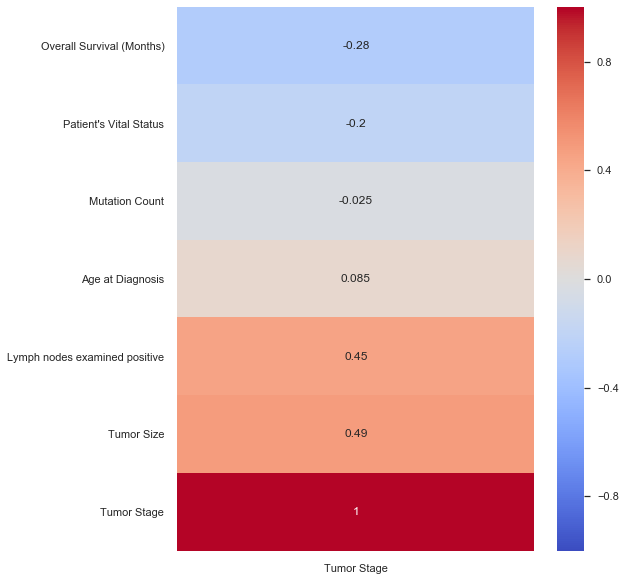

In [33]:
heatmap_numeric_w_dependent_variable(df, 'Tumor Stage')

As we see, Tumor Stage heavily depends of 2 columns (as expected)

It's obvious, that we don't want to just drop this data. The thing we Can do to predict Tumor Stage by other values. 

In [34]:
df['Tumor Stage'] = df['Tumor Stage'].astype('category')

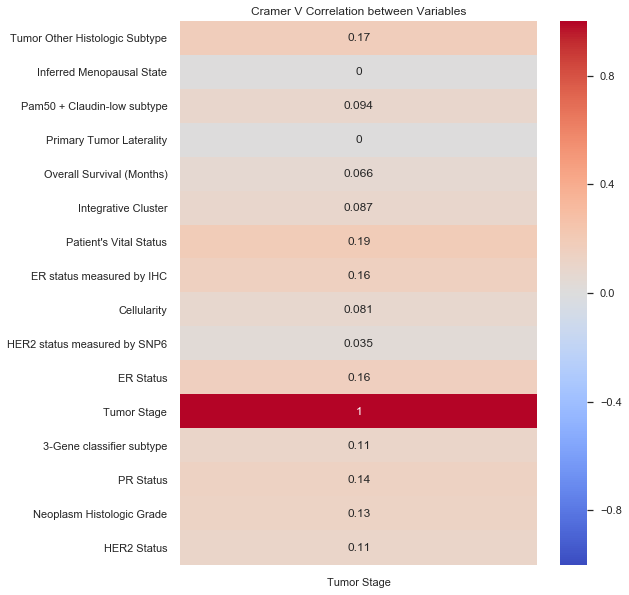

In [35]:
heatmap_categorical_columns_w_dependant_categorical(df, 'Tumor Stage', categorical_cols)

##### Creating various datasets

In [36]:
df_imputed = df.copy()
df_not_nan = df.dropna(subset=['Tumor Stage'])
df_drop = df.drop(columns=['Tumor Stage'])

##### Tumor stage imputation

I will take all correlated-enough features and will predict tumor stage grade, not to lose valuable information

In [37]:
df_to_impute_stage = df_imputed.loc(axis=1)['Tumor Stage', 'Lymph nodes examined positive', 'Tumor Size', 'ER Status', 'Tumor Other Histologic Subtype']

In [38]:
df_to_impute_stage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1914 entries, 0 to 1984
Data columns (total 5 columns):
Tumor Stage                       1415 non-null category
Lymph nodes examined positive     1844 non-null float64
Tumor Size                        1892 non-null float64
ER Status                         1914 non-null object
Tumor Other Histologic Subtype    1914 non-null object
dtypes: category(1), float64(2), object(2)
memory usage: 76.8+ KB


There are few samples, we cannot make prognosis for, because of NaN values in most valuable features - Lymph nodes and Tumor Size. We need to dкop them here and in a main dataset too, to avoid further errors.

In [39]:
indexes = df_to_impute_stage[(df_to_impute_stage['Lymph nodes examined positive'].isnull()) | (df_to_impute_stage['Tumor Size'].isnull())].index

In [40]:
df_to_impute_stage = df_to_impute_stage.drop(indexes)

In [41]:
df_to_impute_stage.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1984
Data columns (total 5 columns):
Tumor Stage                       1356 non-null category
Lymph nodes examined positive     1826 non-null float64
Tumor Size                        1826 non-null float64
ER Status                         1826 non-null object
Tumor Other Histologic Subtype    1826 non-null object
dtypes: category(1), float64(2), object(2)
memory usage: 73.3+ KB


In [42]:
df_imputed = df_imputed.drop(indexes)

In [43]:
df_to_impute_stage_train = df_to_impute_stage[df_to_impute_stage['Tumor Stage'].notnull()]
df_to_impute_stage_impute = df_to_impute_stage.loc[df_to_impute_stage['Tumor Stage'].isnull()]

In [44]:
le = LabelEncoder()
labels = df_to_impute_stage_train[['Tumor Stage']]
enc_labels = le.fit_transform(labels)
print(le.classes_)

[0. 1. 2. 3. 4.]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [45]:
df_to_impute_stage_train = df_to_impute_stage_train.drop(columns=['Tumor Stage'])
df_to_impute_stage_impute = df_to_impute_stage_impute.drop(columns=['Tumor Stage'])

In [46]:
df_to_impute_stage_train_cat = df_to_impute_stage_train[['ER Status', 'Tumor Other Histologic Subtype']]
df_to_impute_stage_train_num = df_to_impute_stage_train[['Lymph nodes examined positive', 'Tumor Size']]

df_to_impute_stage_impute_cat = df_to_impute_stage_impute[['ER Status', 'Tumor Other Histologic Subtype']]
df_to_impute_stage_impute_num = df_to_impute_stage_impute[['Lymph nodes examined positive', 'Tumor Size']]

In [47]:
scaler = StandardScaler()

df_to_impute_stage_train_num_scaled = scaler.fit_transform(df_to_impute_stage_train_num, enc_labels)
df_to_impute_stage_impute_num_scaled = scaler.transform(df_to_impute_stage_impute_num)

In [48]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

df_to_impute_stage_train_cat_oh = enc.fit_transform(df_to_impute_stage_train_cat)
df_to_impute_stage_impute_cat_oh = enc.transform(df_to_impute_stage_impute_cat)

In [49]:
df_to_impute_stage_train_scaled = np.hstack((df_to_impute_stage_train_num_scaled, df_to_impute_stage_train_cat_oh))
df_to_impute_stage_impute_scaled = np.hstack((df_to_impute_stage_impute_num_scaled, df_to_impute_stage_impute_cat_oh))

In [50]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, random_state = 42)   
rf = rf.fit(df_to_impute_stage_train_scaled, enc_labels)

In [51]:
predicted = rf.predict(df_to_impute_stage_impute_scaled)
predicted_labels = le.inverse_transform(predicted)
df_to_impute_stage_impute['Tumor Stage'] = predicted_labels
df_imputed.loc[df_to_impute_stage_impute.index, 'Tumor Stage'] = df_to_impute_stage_impute['Tumor Stage']

In [52]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1984
Data columns (total 20 columns):
Age at Diagnosis                  1826 non-null float64
Cellularity                       1774 non-null object
Pam50 + Claudin-low subtype       1825 non-null object
ER status measured by IHC         1826 non-null object
ER Status                         1826 non-null object
Neoplasm Histologic Grade         1759 non-null category
HER2 status measured by SNP6      1825 non-null object
HER2 Status                       1825 non-null object
Tumor Other Histologic Subtype    1826 non-null object
Inferred Menopausal State         1825 non-null object
Integrative Cluster               1825 non-null object
Primary Tumor Laterality          1726 non-null object
Lymph nodes examined positive     1826 non-null float64
Mutation Count                    1784 non-null float64
Overall Survival (Months)         1826 non-null float64
PR Status                         1825 non-null object
3-Gene 

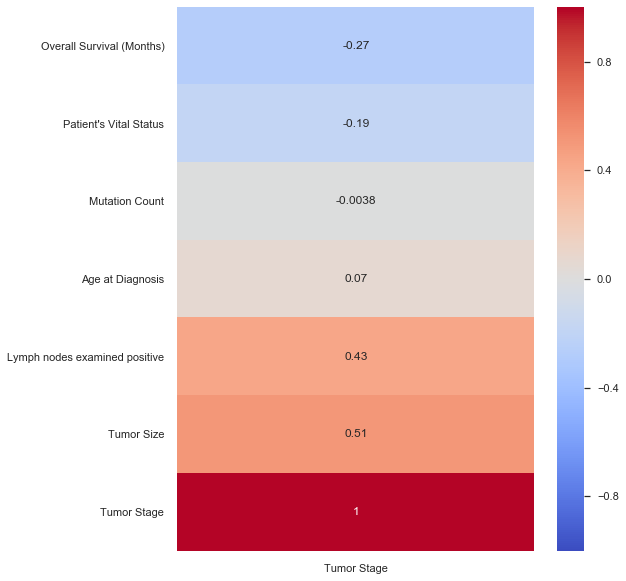

In [53]:
df_imputed['Tumor Stage'] = df_imputed['Tumor Stage'].astype('float64')
heatmap_numeric_w_dependent_variable(df_imputed, 'Tumor Stage')

In [54]:
df_imputed['Tumor Stage'] = df_imputed['Tumor Stage'].astype('category')
df_not_nan['Tumor Stage'] = df_not_nan['Tumor Stage'].astype('category')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [55]:
print(f'Shape of "dropped Stage column df": {df_drop.shape}')
print(f'Shape of "imputed Stage column df": {df_imputed.shape}')
print(f'Shape of "not NaN in Stage column df": {df_not_nan.shape}')

Shape of "dropped Stage column df": (1914, 19)
Shape of "imputed Stage column df": (1826, 20)
Shape of "not NaN in Stage column df": (1415, 20)


#### 3-Gene classifier subtype 

In [56]:
df['3-Gene classifier subtype'].unique()

array(['ER-/HER2-', 'ER+/HER2- High Prolif', nan, 'ER+/HER2- Low Prolif',
       'HER2+'], dtype=object)

In [57]:
df['3-Gene classifier subtype'].value_counts()

ER+/HER2- Low Prolif     617
ER+/HER2- High Prolif    600
ER-/HER2-                296
HER2+                    189
Name: 3-Gene classifier subtype, dtype: int64

Let's check if any other column can explain missing data in this one:

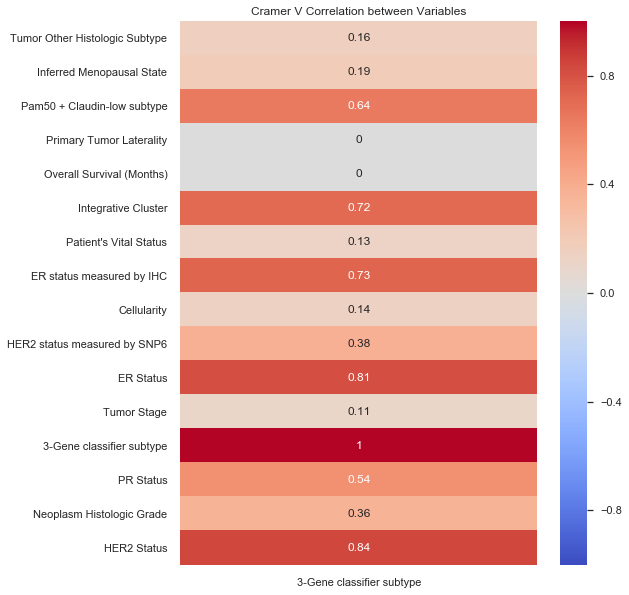

In [58]:
heatmap_categorical_columns_w_dependant_categorical(df, '3-Gene classifier subtype', categorical_cols)

In [59]:
df.loc[df['3-Gene classifier subtype'].isnull()==False][['Integrative Cluster', 'Pam50 + Claudin-low subtype', 'ER Status', 'HER2 Status', '3-Gene classifier subtype']]

,Integrative Cluster,Pam50 + Claudin-low subtype,ER Status,HER2 Status,3-Gene classifier subtype
0,4ER+,claudin-low,Positive,Negative,ER-/HER2-
1,4ER+,LumA,Positive,Negative,ER+/HER2- High Prolif
4,9,LumB,Positive,Negative,ER+/HER2- High Prolif
5,7,LumB,Positive,Negative,ER+/HER2- High Prolif
7,4ER-,Normal,Negative,Negative,ER-/HER2-
...,...,...,...,...,...
1978,3,LumA,Positive,Negative,ER+/HER2- Low Prolif
1979,1,LumB,Positive,Negative,ER+/HER2- High Prolif
1980,3,LumA,Positive,Negative,ER+/HER2- Low Prolif
1983,1,LumB,Positive,Negative,ER+/HER2- High Prolif


In [60]:
df_drop = df_drop.drop(columns=['3-Gene classifier subtype'])
df_not_nan = df_not_nan.dropna(subset=['3-Gene classifier subtype'])

In [61]:
df_to_impute_gene = df_imputed.loc(axis=1)['Integrative Cluster', 'Pam50 + Claudin-low subtype', 'ER Status', 'ER status measured by IHC', 'HER2 Status', 'HER2 status measured by SNP6', '3-Gene classifier subtype']

In [62]:
df_to_impute_gene.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1826 entries, 0 to 1984
Data columns (total 7 columns):
Integrative Cluster             1825 non-null object
Pam50 + Claudin-low subtype     1825 non-null object
ER Status                       1826 non-null object
ER status measured by IHC       1826 non-null object
HER2 Status                     1825 non-null object
HER2 status measured by SNP6    1825 non-null object
3-Gene classifier subtype       1627 non-null object
dtypes: object(7)
memory usage: 194.1+ KB


In [63]:
df_to_impute_gene.loc[df_to_impute_gene['HER2 Status'].isnull()]

,Integrative Cluster,Pam50 + Claudin-low subtype,ER Status,ER status measured by IHC,HER2 Status,HER2 status measured by SNP6,3-Gene classifier subtype
1680,NaN,NaN,Positive,Positve,NaN,NaN,NaN


In [64]:
df_to_impute_gene = df_to_impute_gene.drop(1680)

In [65]:
df_to_impute_gene.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1825 entries, 0 to 1984
Data columns (total 7 columns):
Integrative Cluster             1825 non-null object
Pam50 + Claudin-low subtype     1825 non-null object
ER Status                       1825 non-null object
ER status measured by IHC       1825 non-null object
HER2 Status                     1825 non-null object
HER2 status measured by SNP6    1825 non-null object
3-Gene classifier subtype       1627 non-null object
dtypes: object(7)
memory usage: 114.1+ KB


In [66]:
df_imputed = df_imputed.drop(1680)

In [67]:
df_to_impute_gene_train = df_to_impute_gene[df_to_impute_gene['3-Gene classifier subtype'].notnull()]
df_to_impute_gene_impute = df_to_impute_gene.loc[df_to_impute_gene['3-Gene classifier subtype'].isnull()]

In [68]:
df_to_impute_gene_train.shape[0]

1627

In [69]:
df_to_impute_gene_impute.shape[0]

198

In [70]:
le = LabelEncoder()
labels = df_to_impute_gene_train[['3-Gene classifier subtype']]
enc_labels = le.fit_transform(labels)
print(le.classes_)

['ER+/HER2- High Prolif' 'ER+/HER2- Low Prolif' 'ER-/HER2-' 'HER2+']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [71]:
df_to_impute_gene_train = df_to_impute_gene_train.drop(columns=['3-Gene classifier subtype'])
df_to_impute_gene_impute = df_to_impute_gene_impute.drop(columns=['3-Gene classifier subtype'])

In [72]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
df_to_impute_gene_train_oh = enc.fit_transform(df_to_impute_gene_train)
df_to_impute_gene_impute_oh = enc.transform(df_to_impute_gene_impute)

In [73]:
rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, random_state = 42)   
rf = rf.fit(df_to_impute_gene_train_oh, enc_labels)

In [74]:
predicted = rf.predict(df_to_impute_gene_impute_oh)

In [75]:
predicted_labels = le.inverse_transform(predicted)

In [76]:
df_to_impute_gene_impute['3-Gene classifier subtype'] = predicted_labels

In [77]:
df_to_impute_gene_impute.head(10)

,Integrative Cluster,Pam50 + Claudin-low subtype,ER Status,ER status measured by IHC,HER2 Status,HER2 status measured by SNP6,3-Gene classifier subtype
2,3,LumB,Positive,Positve,Negative,NEUTRAL,ER+/HER2- High Prolif
3,9,LumB,Positive,Positve,Negative,NEUTRAL,ER+/HER2- High Prolif
6,3,LumB,Positive,Positve,Negative,LOSS,ER+/HER2- High Prolif
8,3,claudin-low,Positive,Positve,Negative,NEUTRAL,ER+/HER2- Low Prolif
13,4ER+,LumB,Positive,Positve,Negative,GAIN,ER+/HER2- High Prolif
14,4ER-,claudin-low,Negative,Negative,Negative,NEUTRAL,ER-/HER2-
15,5,LumA,Positive,Positve,Positive,GAIN,HER2+
16,4ER+,claudin-low,Positive,Positve,Positive,GAIN,ER+/HER2- Low Prolif
18,7,LumB,Positive,Positve,Negative,NEUTRAL,ER+/HER2- High Prolif
19,10,LumB,Positive,Positve,Negative,GAIN,ER+/HER2- High Prolif


In [78]:
df_imputed.loc[df_to_impute_gene_impute.index, '3-Gene classifier subtype'] = df_to_impute_gene_impute['3-Gene classifier subtype']

In [79]:
print(f'Shape of "dropped 3-Genes column df": {df_drop.shape}')
print(f'Shape of samples in "imputed 3-Genes column df": {df_imputed.shape}')
print(f'Shape of samples in "not NaN in 3-Genes column df": {df_not_nan.shape}')

Shape of "dropped 3-Genes column df": (1914, 18)
Shape of samples in "imputed 3-Genes column df": (1825, 20)
Shape of samples in "not NaN in 3-Genes column df": (1253, 20)


#### Drop obvious outliers 

In [80]:
print('df_drop')
for i in range(5,10):
    print(f'{df_drop[df_drop.isnull().sum(axis=1) > i].shape[0]} strings with {i} Nan')
print('\n')

print('df_imputed')
for i in range(5,10):
    print(f'{df_imputed[df_imputed.isnull().sum(axis=1) > i].shape[0]} strings with {i} Nan')
print('\n')

print('df_not_nan')
for i in range(5,10):
    print(f'{df_not_nan[df_not_nan.isnull().sum(axis=1) > i].shape[0]} strings with {i} Nan')
print('\n')

df_drop
1 strings with 5 Nan
1 strings with 6 Nan
1 strings with 7 Nan
0 strings with 8 Nan
0 strings with 9 Nan


df_imputed
0 strings with 5 Nan
0 strings with 6 Nan
0 strings with 7 Nan
0 strings with 8 Nan
0 strings with 9 Nan


df_not_nan
0 strings with 5 Nan
0 strings with 6 Nan
0 strings with 7 Nan
0 strings with 8 Nan
0 strings with 9 Nan




In [81]:
df_drop = df_drop.drop(df_drop[df_drop.isnull().sum(axis=1) > 5].index)

In [82]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1913 entries, 0 to 1984
Data columns (total 18 columns):
Age at Diagnosis                  1913 non-null float64
Cellularity                       1852 non-null object
Pam50 + Claudin-low subtype       1913 non-null object
ER status measured by IHC         1913 non-null object
ER Status                         1913 non-null object
Neoplasm Histologic Grade         1831 non-null category
HER2 status measured by SNP6      1913 non-null object
HER2 Status                       1913 non-null object
Tumor Other Histologic Subtype    1913 non-null object
Inferred Menopausal State         1913 non-null object
Integrative Cluster               1913 non-null object
Primary Tumor Laterality          1809 non-null object
Lymph nodes examined positive     1843 non-null float64
Mutation Count                    1801 non-null float64
Overall Survival (Months)         1913 non-null float64
PR Status                         1913 non-null object
Tumor S

#### Other NaNs

In [83]:
print(f'df_drop NaNs drop: {df_drop.shape[0]} -> {df_drop.dropna().shape[0]}')
print(f'df_imputed NaNs drop: {df_imputed.shape[0]} -> {df_imputed.dropna().shape[0]}')
print(f'df_not_nan NaNs drop: {df_not_nan.shape[0]} -> {df_not_nan.dropna().shape[0]}')

df_drop NaNs drop: 1913 -> 1578
df_imputed NaNs drop: 1825 -> 1578
df_not_nan NaNs drop: 1253 -> 1077


In [90]:
any(df_drop.dropna().index == df_imputed.dropna().index)

True

In [91]:
df_drop_after_stage_gene = df_drop.dropna()

In [92]:
dataframes = {
    'df_drop_after_stage_gene': df_drop_after_stage_gene
}

#### Cellularity

The number and type of cells in a given tissue

In [93]:
df_imputed['Cellularity'].value_counts()

High        907
Moderate    679
Low         188
Name: Cellularity, dtype: int64

In [94]:
df_imputed['Cellularity'].isna().sum()

51

In [96]:
df_drop['Cellularity'].isna().sum()

61

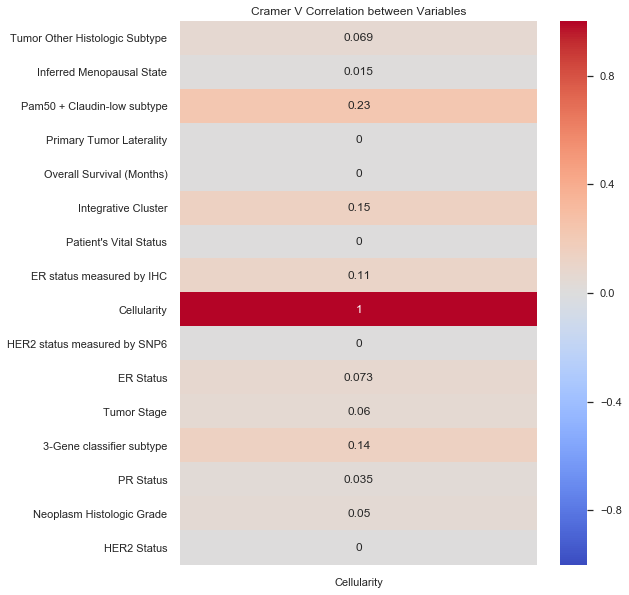

In [95]:
heatmap_categorical_columns_w_dependant_categorical(df_imputed, 'Cellularity', categorical_cols)

There is no correlations with other features - so we got two options - either drop NaN values, or create new category for missing values. I prefer second one. So let's do it in our datasets

In [99]:
df_imputed['Cellularity'] = df_imputed['Cellularity'].astype('category')
df_imputed['Cellularity'] = df_imputed['Cellularity'].cat.add_categories(['Undefined'])
df_imputed['Cellularity'] = df_imputed['Cellularity'].fillna('Undefined')

df_drop['Cellularity'] = df_drop['Cellularity'].astype('category')
df_drop['Cellularity'] = df_drop['Cellularity'].cat.add_categories(['Undefined'])
df_drop['Cellularity'] = df_drop['Cellularity'].fillna('Undefined')

#### Neoplasm Histologic Grade

In [101]:
df_imputed['Neoplasm Histologic Grade'].value_counts()

3.0    893
2.0    710
1.0    155
Name: Neoplasm Histologic Grade, dtype: int64

In [97]:
df_imputed['Neoplasm Histologic Grade'].isna().sum()

67

In [98]:
df_drop['Neoplasm Histologic Grade'].isna().sum()

82

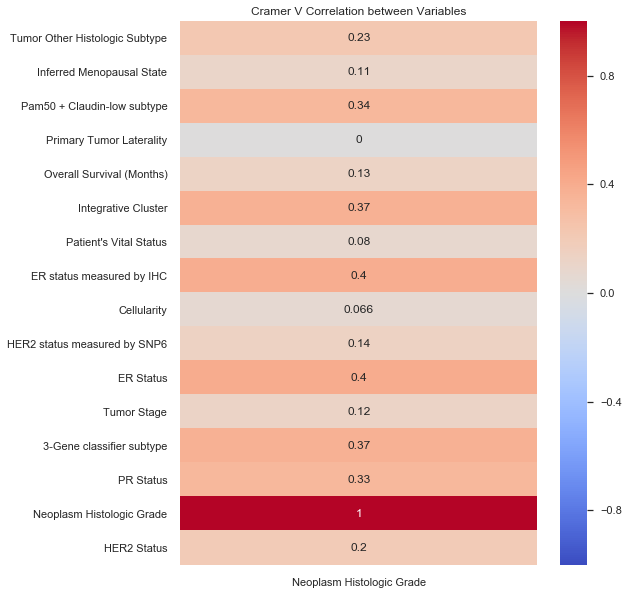

In [100]:
heatmap_categorical_columns_w_dependant_categorical(df_imputed, 'Neoplasm Histologic Grade', categorical_cols)

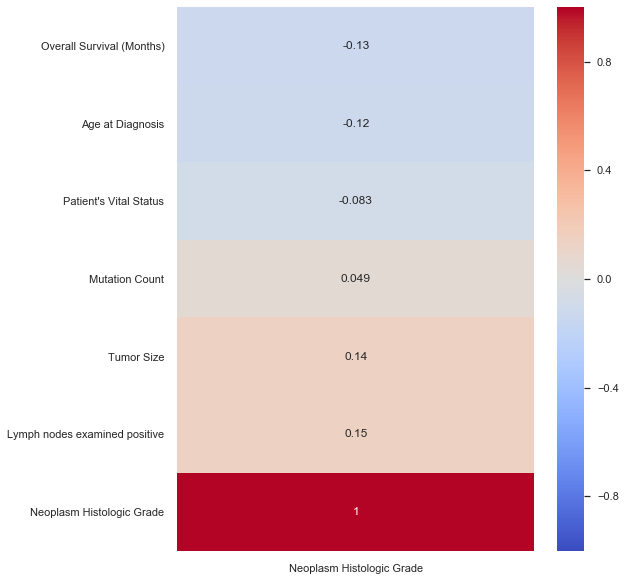

In [103]:
df_imputed['Neoplasm Histologic Grade'] = df_imputed['Neoplasm Histologic Grade'].astype('float64')
heatmap_numeric_w_dependent_variable(df_imputed, 'Neoplasm Histologic Grade')
df_imputed['Neoplasm Histologic Grade'] = df_imputed['Neoplasm Histologic Grade'].astype('category')

It's obvious, that this feature is important - so we cant drop all the column in df_drop. Tho, if we will follow the logic of the distinction between this two dataframes - one contains only clean data, other one allows imputation - the starategy will be drop NaN columns in the first one and input values in the second one.

In [102]:
df_drop = df_drop.dropna(subset=['Neoplasm Histologic Grade'])

In [104]:
df_to_impute_nhg = df_imputed.loc(axis=1)[
    'Integrative Cluster',
    'Pam50 + Claudin-low subtype',
    'ER Status',
    'Tumor Other Histologic Subtype',
    '3-Gene classifier subtype',
    'PR Status',
    'Neoplasm Histologic Grade',
]

In [105]:
df_to_impute_nhg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1825 entries, 0 to 1984
Data columns (total 7 columns):
Integrative Cluster               1825 non-null object
Pam50 + Claudin-low subtype       1825 non-null object
ER Status                         1825 non-null object
Tumor Other Histologic Subtype    1825 non-null object
3-Gene classifier subtype         1825 non-null object
PR Status                         1825 non-null object
Neoplasm Histologic Grade         1758 non-null category
dtypes: category(1), object(6)
memory usage: 181.7+ KB


In [106]:
df_to_impute_nhg_train = df_to_impute_nhg[df_to_impute_nhg['Neoplasm Histologic Grade'].notnull()]
df_to_impute_nhg_impute = df_to_impute_nhg.loc[df_to_impute_nhg['Neoplasm Histologic Grade'].isnull()]

le = LabelEncoder()
labels = df_to_impute_nhg_train[['Neoplasm Histologic Grade']]
enc_labels = le.fit_transform(labels)
print(le.classes_)

df_to_impute_nhg_train = df_to_impute_nhg_train.drop(columns=['Neoplasm Histologic Grade'])
df_to_impute_nhg_impute = df_to_impute_nhg_impute.drop(columns=['Neoplasm Histologic Grade'])

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
df_to_impute_nhg_train_oh = enc.fit_transform(df_to_impute_nhg_train)
df_to_impute_nhg_impute_oh = enc.transform(df_to_impute_nhg_impute)

rf = RandomForestClassifier(n_estimators = 500, max_depth = 10, random_state = 42)   
rf = rf.fit(df_to_impute_nhg_train_oh, enc_labels)

[1. 2. 3.]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [107]:
predicted = rf.predict(df_to_impute_nhg_impute_oh)
predicted_labels = le.inverse_transform(predicted)
df_to_impute_nhg_impute['Neoplasm Histologic Grade'] = predicted_labels
df_imputed.loc[df_to_impute_nhg_impute.index, 'Neoplasm Histologic Grade'] = df_to_impute_nhg_impute['Neoplasm Histologic Grade']

In [108]:
df_to_impute_nhg_impute.head(10)

,Integrative Cluster,Pam50 + Claudin-low subtype,ER Status,Tumor Other Histologic Subtype,3-Gene classifier subtype,PR Status,Neoplasm Histologic Grade
137,4ER+,claudin-low,Positive,Lobular,ER+/HER2- Low Prolif,Positive,2.0
145,5,Her2,Negative,Ductal/NST,HER2+,Negative,3.0
149,8,LumB,Positive,Mixed,ER+/HER2- High Prolif,Positive,2.0
158,3,LumA,Positive,Lobular,ER+/HER2- Low Prolif,Negative,2.0
167,3,LumA,Positive,Ductal/NST,ER+/HER2- Low Prolif,Positive,2.0
170,7,LumA,Positive,Mixed,ER+/HER2- Low Prolif,Positive,2.0
173,8,LumA,Positive,Mixed,ER+/HER2- Low Prolif,Positive,2.0
216,4ER-,Normal,Negative,Other,ER-/HER2-,Negative,2.0
417,8,LumA,Positive,Ductal/NST,ER+/HER2- Low Prolif,Positive,2.0
495,4ER+,Normal,Positive,Other,ER+/HER2- Low Prolif,Positive,3.0


In [109]:
df_imputed['Neoplasm Histologic Grade'].value_counts()

3.0    914
2.0    756
1.0    155
Name: Neoplasm Histologic Grade, dtype: int64

In [110]:
df_imputed['Neoplasm Histologic Grade'].isna().sum()

0

#### Primary Tumor Laterality

In [111]:
df_imputed['Primary Tumor Laterality'].value_counts()

Left     908
Right    818
Name: Primary Tumor Laterality, dtype: int64

In [112]:
df_imputed['Primary Tumor Laterality'].isna().sum()

99

In [113]:
df_drop['Primary Tumor Laterality'].isna().sum()

101

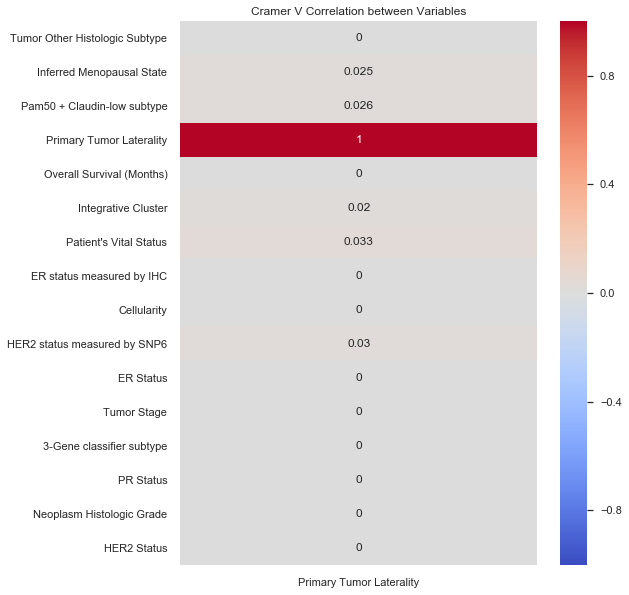

In [114]:
heatmap_categorical_columns_w_dependant_categorical(df_imputed, 'Primary Tumor Laterality', categorical_cols)

It seems, this feature is not important in any of our datasets. Let's just drop it.

In [115]:
df_drop.drop(columns=['Primary Tumor Laterality'], inplace=True)
df_imputed.drop(columns=['Primary Tumor Laterality'], inplace=True)
df_not_nan.drop(columns=['Primary Tumor Laterality'], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Mutation Count

In [116]:
df_imputed['Mutation Count'].isna().sum()

42

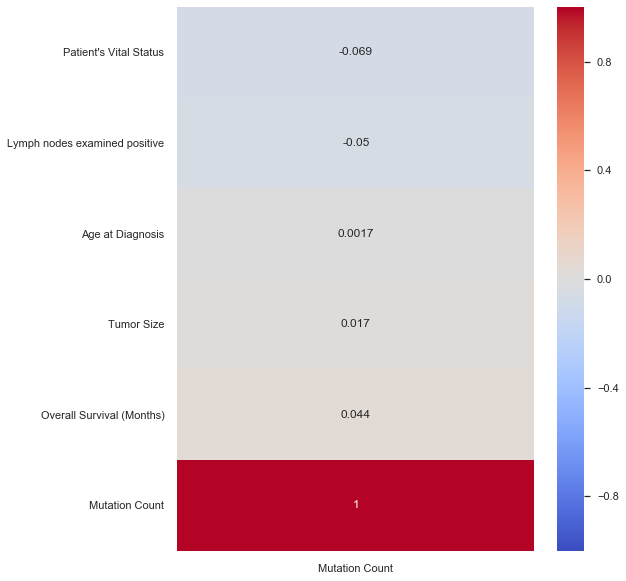

In [117]:
heatmap_numeric_w_dependent_variable(df_imputed, 'Mutation Count')

In [118]:
df_drop.drop(columns=['Mutation Count'], inplace=True)
df_imputed.drop(columns=['Mutation Count'], inplace=True)
df_not_nan.drop(columns=['Mutation Count'], inplace=True)

#### Lymph nodes and Tumor Size in df_drop examined

In [119]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1831 entries, 0 to 1984
Data columns (total 16 columns):
Age at Diagnosis                  1831 non-null float64
Cellularity                       1831 non-null category
Pam50 + Claudin-low subtype       1831 non-null object
ER status measured by IHC         1831 non-null object
ER Status                         1831 non-null object
Neoplasm Histologic Grade         1831 non-null category
HER2 status measured by SNP6      1831 non-null object
HER2 Status                       1831 non-null object
Tumor Other Histologic Subtype    1831 non-null object
Inferred Menopausal State         1831 non-null object
Integrative Cluster               1831 non-null object
Lymph nodes examined positive     1775 non-null float64
Overall Survival (Months)         1831 non-null float64
PR Status                         1831 non-null object
Tumor Size                        1814 non-null float64
Patient's Vital Status            1831 non-null int64
dtypes

In [120]:
df_drop = df_drop.dropna(subset=["Tumor Size", "Lymph nodes examined positive"])

#### Missing values results

In [121]:
df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1758 entries, 0 to 1984
Data columns (total 16 columns):
Age at Diagnosis                  1758 non-null float64
Cellularity                       1758 non-null category
Pam50 + Claudin-low subtype       1758 non-null object
ER status measured by IHC         1758 non-null object
ER Status                         1758 non-null object
Neoplasm Histologic Grade         1758 non-null category
HER2 status measured by SNP6      1758 non-null object
HER2 Status                       1758 non-null object
Tumor Other Histologic Subtype    1758 non-null object
Inferred Menopausal State         1758 non-null object
Integrative Cluster               1758 non-null object
Lymph nodes examined positive     1758 non-null float64
Overall Survival (Months)         1758 non-null float64
PR Status                         1758 non-null object
Tumor Size                        1758 non-null float64
Patient's Vital Status            1758 non-null int64
dtypes

In [122]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1825 entries, 0 to 1984
Data columns (total 18 columns):
Age at Diagnosis                  1825 non-null float64
Cellularity                       1825 non-null category
Pam50 + Claudin-low subtype       1825 non-null object
ER status measured by IHC         1825 non-null object
ER Status                         1825 non-null object
Neoplasm Histologic Grade         1825 non-null category
HER2 status measured by SNP6      1825 non-null object
HER2 Status                       1825 non-null object
Tumor Other Histologic Subtype    1825 non-null object
Inferred Menopausal State         1825 non-null object
Integrative Cluster               1825 non-null object
Lymph nodes examined positive     1825 non-null float64
Overall Survival (Months)         1825 non-null float64
PR Status                         1825 non-null object
3-Gene classifier subtype         1825 non-null object
Tumor Size                        1825 non-null float64
Tumor

In [123]:
df_not_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077 entries, 1 to 1743
Data columns (total 18 columns):
Age at Diagnosis                  1077 non-null float64
Cellularity                       1077 non-null object
Pam50 + Claudin-low subtype       1077 non-null object
ER status measured by IHC         1077 non-null object
ER Status                         1077 non-null object
Neoplasm Histologic Grade         1077 non-null category
HER2 status measured by SNP6      1077 non-null object
HER2 Status                       1077 non-null object
Tumor Other Histologic Subtype    1077 non-null object
Inferred Menopausal State         1077 non-null object
Integrative Cluster               1077 non-null object
Lymph nodes examined positive     1077 non-null float64
Overall Survival (Months)         1077 non-null float64
PR Status                         1077 non-null object
3-Gene classifier subtype         1077 non-null object
Tumor Size                        1077 non-null float64
Tumor S

In [124]:
df_drop_after_stage_gene.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1578 entries, 1 to 1982
Data columns (total 18 columns):
Age at Diagnosis                  1578 non-null float64
Cellularity                       1578 non-null object
Pam50 + Claudin-low subtype       1578 non-null object
ER status measured by IHC         1578 non-null object
ER Status                         1578 non-null object
Neoplasm Histologic Grade         1578 non-null category
HER2 status measured by SNP6      1578 non-null object
HER2 Status                       1578 non-null object
Tumor Other Histologic Subtype    1578 non-null object
Inferred Menopausal State         1578 non-null object
Integrative Cluster               1578 non-null object
Primary Tumor Laterality          1578 non-null object
Lymph nodes examined positive     1578 non-null float64
Mutation Count                    1578 non-null float64
Overall Survival (Months)         1578 non-null float64
PR Status                         1578 non-null object
Tumor S

### Transformation

In [127]:
df_drop_after_stage_gene_transformed = df_drop_after_stage_gene.copy(deep=True)
df_drop_transformed = df_drop.copy(deep=True)
df_imputed_transformed = df_imputed.copy(deep=True)
df_not_nan_transformed = df_not_nan.copy(deep=True)

#### Lymph nodes

In [125]:
df['Lymph nodes examined positive'].unique()

array([10.,  0.,  1.,  3.,  8., nan, 24.,  4., 16.,  5., 14.,  6.,  2.,
        9., 22.,  7., 21., 13., 12., 25., 41., 11., 19., 15., 17., 18.,
       23., 26., 20., 31., 33., 45.])

Text(0.5, 0, 'Lymph nodes examined positive')

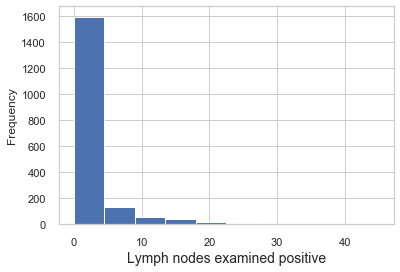

In [126]:
df['Lymph nodes examined positive'].plot.hist()
plt.xlabel('Lymph nodes examined positive', fontsize=14)

Text(0.5, 0, 'Log Lymph nodes examined positive')

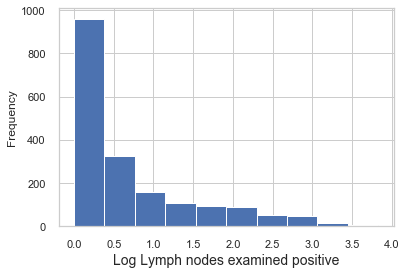

In [229]:
f = df['Lymph nodes examined positive']
f_log = f.map(lambda x: np.log(x+1))

f_log.plot.hist()
plt.xlabel('Log Lymph nodes examined positive', fontsize=14)

In [230]:
df_drop_transformed['Lymph nodes examined positive'] = df_drop_transformed['Lymph nodes examined positive'].apply(lambda x: np.log(x+1))
df_imputed_transformed['Lymph nodes examined positive'] = df_imputed_transformed['Lymph nodes examined positive'].apply(lambda x: np.log(x+1))
df_not_nan_transformed['Lymph nodes examined positive'] = df_not_nan_transformed['Lymph nodes examined positive'].apply(lambda x: np.log(x+1))

#### Mutation Count

In [ ]:
df['Mutation Count'].plot.hist()
plt.xlabel('Mutation Count', fontsize=14)

In [ ]:
f = df['Mutation Count']
f_log = f.map(lambda x: np.log(x+1))

f_log.plot.hist()
plt.xlabel('Log Lymph nodes examined positive', fontsize=14)

In [ ]:
for df in dataframes_t:
    df['Mutation Count'] = df['Mutation Count'].apply(lambda x: np.log(x+1))

#### Tumor Size

In [ ]:
df['Tumor Size'].plot.hist()
plt.xlabel('Tumor Size', fontsize=14)

In [ ]:
f = df['Tumor Size']
f_log = f.map(lambda x: np.log(x+1))

f_log.plot.hist()
plt.xlabel('Tumor Size', fontsize=14)

In [231]:
df_drop_transformed['Tumor Size'] = df_drop_transformed['Tumor Size'].apply(lambda x: np.log(x+1))
df_imputed_transformed['Tumor Size'] = df_imputed_transformed['Tumor Size'].apply(lambda x: np.log(x+1))
df_not_nan_transformed['Tumor Size'] = df_not_nan_transformed['Tumor Size'].apply(lambda x: np.log(x+1))

#### Results

In [ ]:
df_drop_transformed['Tumor Size'].unique()

In [ ]:
df_drop['Tumor Size'].unique()

### Separating target

In [128]:
df_drop_labels = df_drop["Patient's Vital Status"]
df_imputed_labels = df_imputed["Patient's Vital Status"]
df_not_nan_labels = df_not_nan["Patient's Vital Status"]
df_drop_after_stage_gene_labels = df_drop_after_stage_gene["Patient's Vital Status"]

df_drop.drop(columns=["Patient's Vital Status", 'Overall Survival (Months)'], inplace=True)
df_imputed.drop(columns=["Patient's Vital Status", 'Overall Survival (Months)'], inplace=True)
df_not_nan.drop(columns=["Patient's Vital Status", 'Overall Survival (Months)'], inplace=True)
df_drop_after_stage_gene.drop(columns=["Patient's Vital Status", 'Overall Survival (Months)'], inplace=True)

df_drop_transformed.drop(columns=["Patient's Vital Status", 'Overall Survival (Months)'], inplace=True)
df_imputed_transformed.drop(columns=["Patient's Vital Status", 'Overall Survival (Months)'], inplace=True)
df_not_nan_transformed.drop(columns=["Patient's Vital Status", 'Overall Survival (Months)'], inplace=True)
df_drop_after_stage_gene_transformed.drop(columns=["Patient's Vital Status", 'Overall Survival (Months)'], inplace=True)

### Working with categorical features

In [265]:
data = df_imputed_transformed
labels = df_imputed_labels

In [266]:
numeric_cols = ['Age at Diagnosis', 'Lymph nodes examined positive', 'Tumor Size']

categorical_cols = list(set(data.columns.values.tolist()) - set(numeric_cols))

In [267]:
data_cat = data[categorical_cols]
data_num = data[numeric_cols]

In [268]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
data_cat_oh = enc.fit_transform(data_cat)

### Splitting dataset

In [269]:
(X_train_num, X_test_num, y_train, y_test) = train_test_split(data_num, labels, 
                                                              test_size=0.3, 
                                                              random_state=42,
                                                              stratify=labels)

(X_train_cat_oh, X_test_cat_oh) = train_test_split(data_cat_oh, 
                                                   test_size=0.3, 
                                                   random_state=42,
                                                   stratify=labels)

### Numerical features scaling

In [270]:
scaler = StandardScaler()

X_train_num_scaled = scaler.fit_transform(X_train_num, y_train)
X_test_num_scaled = scaler.transform(X_test_num)

### Making final train and test datasets

In [271]:
X_train_scaled = np.hstack((X_train_num_scaled, X_train_cat_oh))
X_test_scaled = np.hstack((X_test_num_scaled, X_test_cat_oh))

### Class Balancing

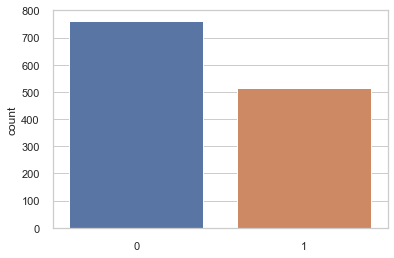

In [215]:
sns.countplot(y_train.values)

In [ ]:
num_of_indices = np.sum(y_train==0) - np.sum(y_train==1)
print(np.sum(y_train==0))
print(np.sum(y_train==1))

indexes_of_first_class = np.where(y_train==1)[0]

In [ ]:
indices_to_add = np.random.choice(list(indexes_of_first_class), size=num_of_indices)

X_train_to_add = X_train_scaled.take(indices_to_add, axis=0)
y_train_to_add = y_train.take(indices_to_add)

print(np.sum(y_train_to_add))

In [ ]:
#new X, y train
X_train_balanced = np.vstack((X_train_scaled, X_train_to_add))
y_train_balanced = np.append(y_train, y_train_to_add)

print (X_train_balanced.shape, X_train_scaled.shape)
print (y_train_balanced.shape, y_train.shape)

In [ ]:
sns.countplot(y_train_balanced)

# Models

In [272]:
X_train = X_train_scaled
y_train = y_train

## Random Forest

Accuracy is:  0.6691712676602044


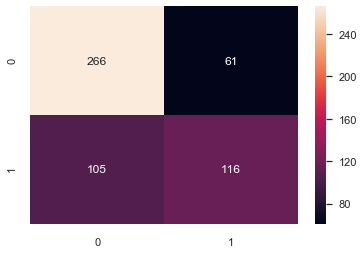

In [273]:
#random forest classifier with n_estimators=10 (default)
clf_rf = RandomForestClassifier(n_estimators = 200, max_depth = 7, max_features=40, random_state = 42)   
clr_rf = clf_rf.fit(X_train, y_train)

ac = roc_auc_score(y_test,clf_rf.predict(X_test_scaled))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,clf_rf.predict(X_test_scaled))
sns.heatmap(cm,annot=True,fmt="d")

ypred = clf_rf.predict(X_test_scaled)

In [274]:
clf = svm.SVC(C=0.5, kernel='rbf', degree=3, gamma='scale', tol=0.001, probability=True)

clf.fit(X_train, y_train)

roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1])

0.7359237272890807

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 42)

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(rf_classifier, X_train, y_train, 
                                                        train_sizes=np.arange(0.1,1., 0.1), 
                                                        cv=3, scoring='accuracy')

In [ ]:
print (train_sizes)
print (train_scores.mean(axis = 1))
print (test_scores.mean(axis = 1))

In [ ]:
plt.plot(train_sizes, train_scores.mean(axis = 1), 'g-', marker='o', label='train')
plt.plot(train_sizes, test_scores.mean(axis = 1), 'r-', marker='o', label='test')
plt.ylim((0.0, 1.05))
plt.legend(loc='lower right')

In [137]:
n_trees = [1] + list(range(10, 500, 5))

In [139]:
from sklearn.model_selection import cross_val_score

scoring = []
for n_tree in n_trees:
    estimator = RandomForestClassifier(n_estimators = n_tree, max_depth = 10, max_features=20, min_samples_split=5, random_state=42)
    score = cross_val_score(estimator, X_train, y_train, 
                            scoring = 'accuracy', cv = 5)    
    scoring.append(score)
scoring = np.asmatrix(scoring)

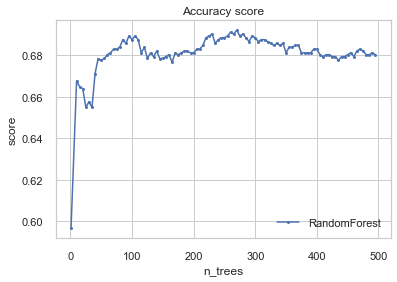

In [143]:
plt.plot(n_trees, scoring.mean(axis = 1), marker='.', label='RandomForest')
plt.grid(True)
plt.xlabel('n_trees')
plt.ylabel('score')
plt.title('Accuracy score')
plt.legend(loc='lower right')

In [ ]:
depths = list(range(1, 20))

In [ ]:
scoring = []
for depth in depths:
    estimator = RandomForestClassifier(
        n_estimators = 1500,
        max_depth = depth,
        random_state=42,
        min_samples_split = 2,
        min_samples_leaf = 4,
        bootstrap=True
    ) 
    estimator = estimator.fit(X_train_balanced, y_train_balanced)
    score = accuracy_score(y_test, estimator.predict(X_test_scaled))
    scoring.append(score)

In [ ]:
plt.plot(depths, scoring, marker='.', label='RandomForest')
plt.grid(True)
plt.xlabel('depth')
plt.ylabel('score')
plt.title('Accuracy score')
plt.legend(loc='lower right')

In [ ]:

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_train_balanced, y_train_balanced)

In [ ]:
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy_score(y_test, predictions)))

In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_scaled, y_test)

In [ ]:

print(classification_report(ypred, ytest))

## GB

In [301]:
from sklearn.ensemble import GradientBoostingClassifier

lr_list = [0.01, 0.05, 0.075, 0.1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=learning_rate, max_features=20, max_depth=5, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test_scaled, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.859
Accuracy score (validation): 0.695
Learning rate:  0.075
Accuracy score (training): 0.881
Accuracy score (validation): 0.666
Learning rate:  0.1
Accuracy score (training): 0.919
Accuracy score (validation): 0.682
Learning rate:  0.25
Accuracy score (training): 0.993
Accuracy score (validation): 0.661
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.670
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.657
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.646


In [307]:
n_estimators = [100, 130, 150, 160, 180, 200]
train_results = []
test_results = []

for estimator in n_estimators:
    gb_clf = GradientBoostingClassifier(n_estimators=estimator, learning_rate=0.05, max_features=20, max_depth=5, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("n_estimators: ", estimator)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test_scaled, y_test)))

n_estimators:  100
Accuracy score (training): 0.859
Accuracy score (validation): 0.695
n_estimators:  130
Accuracy score (training): 0.880
Accuracy score (validation): 0.692
n_estimators:  150
Accuracy score (training): 0.890
Accuracy score (validation): 0.695
n_estimators:  160
Accuracy score (training): 0.901
Accuracy score (validation): 0.686
n_estimators:  180
Accuracy score (training): 0.919
Accuracy score (validation): 0.675
n_estimators:  200
Accuracy score (training): 0.927
Accuracy score (validation): 0.672


In [313]:
max_depths = np.linspace(1, 12, 12, endpoint=True)
train_results = []
test_results = []

for depth in max_depths:
    gb_clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_features=40, max_depth=depth, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("depth:", depth)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test_scaled, y_test)))

depth: 1.0
Accuracy score (training): 0.714
Accuracy score (validation): 0.681
depth: 2.0
Accuracy score (training): 0.735
Accuracy score (validation): 0.688
depth: 3.0
Accuracy score (training): 0.780
Accuracy score (validation): 0.706
depth: 4.0
Accuracy score (training): 0.829
Accuracy score (validation): 0.690
depth: 5.0
Accuracy score (training): 0.903
Accuracy score (validation): 0.684
depth: 6.0
Accuracy score (training): 0.966
Accuracy score (validation): 0.664
depth: 7.0
Accuracy score (training): 0.991
Accuracy score (validation): 0.653
depth: 8.0
Accuracy score (training): 0.998
Accuracy score (validation): 0.642
depth: 9.0
Accuracy score (training): 0.999
Accuracy score (validation): 0.664


KeyboardInterrupt: 

In [312]:
max_features = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
train_results = []
test_results = []

for features in max_features:
    gb_clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_features=features, max_depth=3, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("features:", features)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test_scaled, y_test)))

features: 5
Accuracy score (training): 0.743
Accuracy score (validation): 0.681
features: 10
Accuracy score (training): 0.751
Accuracy score (validation): 0.693
features: 15
Accuracy score (training): 0.764
Accuracy score (validation): 0.701
features: 20
Accuracy score (training): 0.764
Accuracy score (validation): 0.697
features: 25
Accuracy score (training): 0.769
Accuracy score (validation): 0.701
features: 30
Accuracy score (training): 0.773
Accuracy score (validation): 0.697
features: 35
Accuracy score (training): 0.775
Accuracy score (validation): 0.699
features: 40
Accuracy score (training): 0.780
Accuracy score (validation): 0.706
features: 45
Accuracy score (training): 0.781
Accuracy score (validation): 0.692
features: 50
Accuracy score (training): 0.780
Accuracy score (validation): 0.697


In [316]:
min_samples_splits = np.linspace(0.01, 0.1, 10, endpoint=True)
train_results = []
test_results = []

for splits in min_samples_splits:
    gb_clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_features=40, max_depth=3, min_samples_split=splits, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("splits:", splits)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test_scaled, y_test)))

splits: 0.01
Accuracy score (training): 0.775
Accuracy score (validation): 0.701
splits: 0.020000000000000004
Accuracy score (training): 0.772
Accuracy score (validation): 0.706
splits: 0.030000000000000006
Accuracy score (training): 0.766
Accuracy score (validation): 0.699
splits: 0.04000000000000001
Accuracy score (training): 0.771
Accuracy score (validation): 0.695
splits: 0.05000000000000001
Accuracy score (training): 0.760
Accuracy score (validation): 0.692
splits: 0.06000000000000001
Accuracy score (training): 0.763
Accuracy score (validation): 0.701
splits: 0.07
Accuracy score (training): 0.761
Accuracy score (validation): 0.693
splits: 0.08
Accuracy score (training): 0.753
Accuracy score (validation): 0.703
splits: 0.09000000000000001
Accuracy score (training): 0.751
Accuracy score (validation): 0.699
splits: 0.1
Accuracy score (training): 0.749
Accuracy score (validation): 0.701


In [319]:
min_samples_leafs = np.linspace(0.001, 0.005, 5, endpoint=True)
train_results = []
test_results = []

for leafs in min_samples_leafs:
    gb_clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_features=40, max_depth=3, min_samples_split=0.1, min_samples_leaf=0.03, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("leafs:", leafs)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test_scaled, y_test)))

leafs: 0.001
Accuracy score (training): 0.752
Accuracy score (validation): 0.693
leafs: 0.002
Accuracy score (training): 0.756
Accuracy score (validation): 0.703
leafs: 0.003
Accuracy score (training): 0.755
Accuracy score (validation): 0.703
leafs: 0.004
Accuracy score (training): 0.753
Accuracy score (validation): 0.695
leafs: 0.005
Accuracy score (training): 0.748
Accuracy score (validation): 0.699


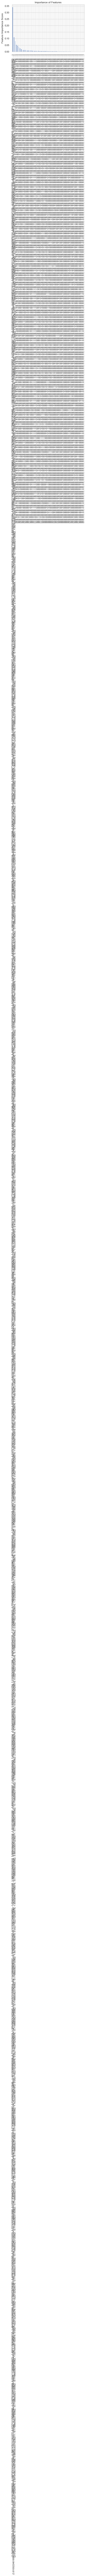

In [324]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report


baseline = GradientBoostingClassifier(learning_rate=0.05, n_estimators=150, max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(X_train,y_train)
predictors=list(X_train)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
plt.show()

## Naive Bayes classifier

In [275]:
bnb = BernoulliNB()
mnb = MultinomialNB()
gnb = GaussianNB()

In [276]:
score_bnb = cross_val_score(bnb, X_train, y_train)
# score_mnb_dig = cross_val_score(mnb, X_train_balanced, y_train_balanced)
score_gnb = cross_val_score(gnb, X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [277]:
print('Breast cancer dataset')
print('BernoulliNB mean cross_val_score: ' + str(score_bnb.mean()))
print('GaussianNB mean cross_val_score: ' + str(score_gnb.mean()))

Breast cancer dataset
BernoulliNB mean cross_val_score: 0.649159532357544
GaussianNB mean cross_val_score: 0.5380355334622112


## Logistic Regression

In [141]:
def plot_scores(optimizer):
    param_C = np.array(optimizer.cv_results_['param_C'])
    mean_cv = optimizer.cv_results_['mean_test_score']
    std_cv = optimizer.cv_results_['std_test_score']
    
    temp_1 = mean_cv - std_cv
    temp_2 = mean_cv + std_cv                                             
    
    plt.semilogx(param_C, mean_cv)
    plt.fill_between(np.array(param_C, dtype=float), np.array(temp_1, dtype=float), np.array(temp_2, dtype=float), alpha=0.3)
    plt.show()

In [328]:
param_grid = {'C': [0.001, 0.001, 0.1, 0.5, 1, 5, 10]}
cv = 5

estimator = LR(solver='liblinear')

optimizer_zeros = GridSearchCV(estimator, param_grid, cv=cv, scoring='')
optimizer_zeros.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.001, 0.1, 0.5, 1, 5, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

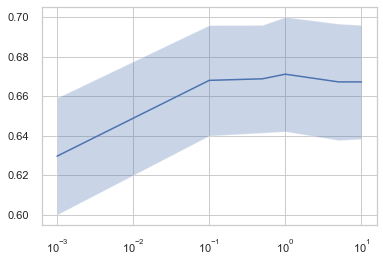

In [283]:
plot_scores(optimizer_zeros)

In [284]:
roc_auc_score_zeros = roc_auc_score(y_test, optimizer_zeros.best_estimator_.predict_proba(X_test_scaled)[:, 1])

In [285]:
roc_auc_score_zeros

0.7429117024367969

## SVM

In [140]:
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, 0.5, 1, 2, 3, 4, 5, 10, 20, 50, 100]}
svc = svm.SVC(probability=True)

clf = GridSearchCV(svc, parameters, cv=5)

clf.fit(X_train, y_train)

plot_scores(clf)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this 

NameError: name 'plot_scores' is not defined

In [170]:
clf = svm.SVC(C=0.5, kernel='rbf', degree=3, gamma='scale', tol=0.001, probability=True)

clf.fit(X_train, y_train)

roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:, 1])

0.734650670430487

In [165]:
clf.best_estimator_

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [142]:
roc_auc_score(y_test, clf.best_estimator_.predict_proba(X_test_scaled)[:, 1])

0.7251673335423082

## KNN

In [292]:
knn_cv = KNeighborsClassifier(n_neighbors=20)

cv_scores = cross_val_score(knn_cv, X_train, y_train, cv=5)

print(cv_scores)
print("cv_scores mean:{}".format(np.mean(cv_scores)))

[0.6640625  0.69921875 0.63137255 0.69019608 0.63137255]
cv_scores mean:0.6632444852941176


In [287]:
knn2 = KNeighborsClassifier()

param_grid = {"n_neighbors": np.arange(1, 50)}

knn_gscv = GridSearchCV(knn2, param_grid, cv=10)

knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [288]:
knn_gscv.best_params_

{'n_neighbors': 49}

In [290]:
# creating odd list of K for KNN
neighbors = list(range(1, 50, 2))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

The optimal number of neighbors is 49


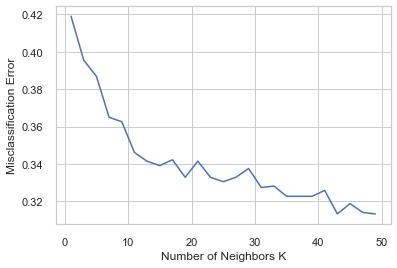

In [291]:
# changing to misclassification error
mse = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbors is {}".format(optimal_k))

# plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Misclassification Error")
plt.show()

## MLP

In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(13,13,13),
    activation='relu',
    solver='adam',
    max_iter=1000,
)

mlp.fit(X_train, y_train)

predict_train = mlp.predict(X_train)
predict_test = mlp.predict(X_test_scaled)

In [ ]:


print(confusion_matrix(y_train, predict_train))
print(classification_report(y_train, predict_train))

In [ ]:
print(confusion_matrix(y_test, predict_test))
print(classification_report(y_test, predict_test))

In [293]:
mlp = MLPClassifier(max_iter=500)

In [294]:
parameter_space = {
    'hidden_layer_sizes': [(8,8,8), (50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [297]:
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)

clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=500,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_sta...
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alph

In [298]:
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'sgd'}


In [299]:
y_true, y_pred = y_test , clf.predict(X_test_scaled)

print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75       327
           1       0.62      0.50      0.55       221

    accuracy                           0.68       548
   macro avg       0.66      0.65      0.65       548
weighted avg       0.67      0.68      0.67       548



## Sequential NN

In [ ]:
X_train_balanced.shape[1]

In [ ]:
# MLP for Pima Indians Dataset with 10-fold cross validation via sklearn


def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(49, input_dim=49, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# evaluate model with standardized dataset

estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)

kfold = StratifiedKFold(n_splits=10, shuffle=True)

results = cross_val_score(estimator, X_train_balanced, y_train_balanced, cv=kfold)

print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(49, input_dim=49, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
# evaluate model with standardized dataset

In [ ]:
estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)

kfold = StratifiedKFold(n_splits=10, shuffle=True)

results = cross_val_score(estimator, X_train_balanced, y_train_balanced, cv=kfold)

print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
model = KerasClassifier(build_fn=create_baseline, verbose=0)
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]

param_grid = {
    'epochs' : epochs,
    'batch_size' : batches,
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)

grid_result = grid.fit(X_train_balanced, y_train_balanced)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

# Selecting Model

I selected Random Forest as my model. The appropriate metric for the model will be will False negative rate, as we defienetly dont want to predict dead status for patients. We can afford lowering probability in True positive for the cost of ...

### How iterative changes in the feature creation task influence it.

### AD Documeте preparation

During the curse of the project you’ve made several choices which impact the project. Now it’s time to do a final pass on the document and make sure everything is in shape. Please spend some time on it to really make sure everything is consistent. Imagine, that your successor needs to continue with your project without being able to speak to you, so this document is the only way to understand why and how things are implemented as they are.